In [6]:
# imports and functions

import torch
import numpy as np
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

from models.registration_model import RegistrationModel
import registration # loads the package not the file
import utils

In [2]:
# load the model
ckpt_path = "/data/vision/polina/users/layjain/ivus-temporal/checkpoints/registration/1/3-1-1_len30-epochs500-mlp2-lossMSE-lr0.001/saved_models/model_499.pth"

def load_model(ckpt_path):
    checkpoint = torch.load(ckpt_path)
    model = RegistrationModel(checkpoint['args'])
    model_dict = model.state_dict()
    model_dict.update(checkpoint['model'])
    model.load_state_dict(model_dict)
    # print(f"Loaded keys \n {model_dict.keys()}")
    return model

def get_dataloader(ckpt_path, mode="train"):
    checkpoint = torch.load(ckpt_path)
    args = checkpoint['args']
    args.use_cached_dataset = True # Override
    # begin: copy of get_dataloader from registration.py
    from data.hdf5_clips import UnlabelledClips
    from torch.utils.data import DataLoader
    root = os.path.join(args.data_path, mode)
    save_file = f"/data/vision/polina/users/layjain/pickled_data/pretraining/ivus_{mode}_len_{args.clip_len}.h5"
    dataset = UnlabelledClips(root, frames_per_clip=args.clip_len, transform=None, cached=args.use_cached_dataset, save_img_size=args.img_size, save_file=save_file)
    print(f"Dataset size: {len(dataset)}")
    dataloader = DataLoader(dataset, batch_size=args.batch_size, pin_memory=True, num_workers = args.workers, shuffle=True)
    return dataloader
    
model = load_model(ckpt_path)
model.eval()
dataloader = get_dataloader(ckpt_path)
print(model)

stride Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
stride Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
stride Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
stride Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
stride Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
stride Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
stride Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
stride Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
stride Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
stride Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Loading cached data from /data/vision/polina/users/layjain/pickled_data/pretraining/ivus_train_len_30.h5
Dataset size: 2228
RegistrationModel(
  (encoder_localize

In [53]:
def get_clip_np(images, model, idx=0):
    B, T, H, W, C = images.shape
    assert C==1
    assert H==W
    images = images.transpose(2, 4) # B x T x C x W x H
    images_tr, template = model(images) # B x T x W x H, B x 8 x 1 x W x H, because of mistake
    p = model.encoder_localizer(images)
    p = p.view(B, T, 3)  # B x T x 3
    p = p[idx].detach().numpy()
    template = template[:,0,...]
    mean_frames = torch.mean(images, dim=1, keepdim=False)
    images_batch = images[idx].squeeze().detach().numpy()
    images_tr_batch = images_tr[idx].squeeze().detach().numpy() # T x W x H 
    template_batch = np.repeat(template[idx].detach().numpy(), T, axis=0)
    mean_frames_batch = np.repeat(mean_frames[idx].detach().numpy(), T, axis=0)
#     print(template.shape, template_batch.shape)
    images_concat = np.concatenate([images_batch, images_tr_batch,template_batch, mean_frames_batch], axis = 2) # T x W x 2H
    mse_in = registration.registration_loss.MSE_loss(torch.from_numpy(images_batch), torch.from_numpy(template_batch))
    mse_out = registration.registration_loss.MSE_loss(torch.from_numpy(images_tr_batch), torch.from_numpy(template_batch))
    return images_concat, mse_in, mse_out, p

def clip_to_movie(clip_np):
    T, W, H = clip_np.shape
    
    import matplotlib.animation as animation

    fig = plt.figure()

    im = plt.imshow(clip_np[0], cmap='gray')
    plt.axis('off')

    def animate_func(i):
        im.set_array(clip_np[i])
        return [im]

    anim = animation.FuncAnimation(
                                   fig, 
                                   animate_func, 
                                   frames = T,
    )
    plt.close()
    return anim
    HTML(anim.to_jshtml())

images = next(iter(dataloader))
clip_np, mse_in, mse_out, transform_parameters = get_clip_np(images, model)
print(f"MSE: {mse_in} --> {mse_out}")
anim = clip_to_movie(clip_np)
from IPython.display import HTML
import matplotlib.animation as animation
FFwriter = animation.FFMpegWriter(fps=10)
anim.save('del.mp4', writer = FFwriter)
HTML(anim.to_jshtml())

MSE: 0.016460774466395378 --> 0.01600874401628971
2023-03-07 17:44:28,236 - Animation.save using <class 'matplotlib.animation.HTMLWriter'>
2023-03-07 17:44:29,905 - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-03-07 17:44:29,908 - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y del.mp4


In [58]:
HTML(anim.to_jshtml())

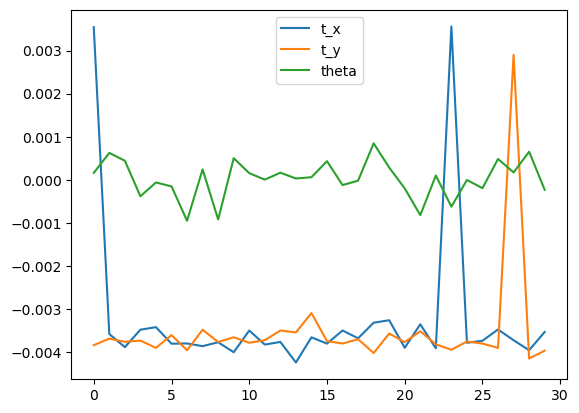

In [59]:
t_x, t_y, r = transform_parameters[...,0], transform_parameters[...,1], transform_parameters[...,2]
plt.plot(t_x, label='t_x')
plt.plot(t_y, label='t_y')
plt.plot(r, label='theta')
plt.legend()
plt.show(); plt.close()

In [36]:
idx = 0
images = next(iter(dataloader))

B, T, H, W, C = images.shape
assert C==1
assert H==W
images = images.transpose(2, 4) # B x T x C x W x H
images_tr, template = model(images) # B x T x W x H, B x 1 x W x H

print(images.shape, images.dtype) # B x T x C x W x H
print(model.unet(images.squeeze()).shape) # B x C x W x H
print(torch.mean(images, dim=1, keepdim=False).shape) # B x C x W x H
print((model.unet(images.squeeze()) + torch.mean(images, dim=1, keepdim=False)).shape,template.shape) # B x B x C x W x H

true_template = model.unet(images.squeeze()) + torch.mean(images, dim=1, keepdim=False)
print(images_tr.shape, true_template.shape)
print((images_tr-template).shape)

torch.Size([8, 30, 1, 256, 256]) torch.float32
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256]) torch.Size([8, 8, 1, 256, 256])
torch.Size([8, 30, 256, 256]) torch.Size([8, 1, 256, 256])
torch.Size([8, 8, 30, 256, 256])


In [35]:
np.min(model.unet(images.squeeze()).detach().numpy())

-81.69452

In [41]:
utils.count_parameters(model)/10**6

3.891857